# Finding Vanishing Points within an image

### Ex 4.14 : Vanishing Points - Computer the vanishing points in an image using one of the techniquest described in Section 4.3.3 and optionally refine the original line equations associated with each vanishing point. 


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.feature import canny
from skimage import data, color, feature, transform
from skimage.measure import LineModelND, ransac
from matplotlib import cm
from tqdm import tqdm
from scipy.cluster.vq import kmeans2

In [3]:
img = skimage.io.imread('./test-image2.png')

## We chose this image for the obvious vanishing point and the lax of external lines not related to the vanishing point

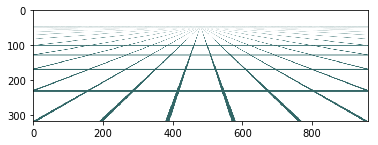

In [4]:
imshow(img)

In [5]:
image = skimage.color.rgb2gray(img)
edges = canny(image)

### The next two cells have code from http://scikit-image.org/docs/dev/auto_examples/edges/plot_line_hough_transform.html

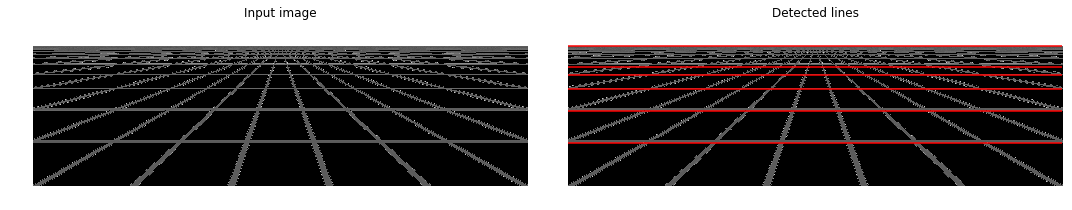

In [6]:
# Classic straight-line Hough transform
h, theta, d = hough_line(edges)

# Generating figure 1
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(image, cmap=cm.gray)
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
    ax[1].plot((0, image.shape[1]), (y0, y1), '-r')
ax[1].set_xlim((0, image.shape[1]))
ax[1].set_ylim((image.shape[0], 0))
ax[1].set_axis_off()
ax[1].set_title('Detected lines')

plt.tight_layout()
plt.show()

## Computing the probabilistic hough transform on the canny image

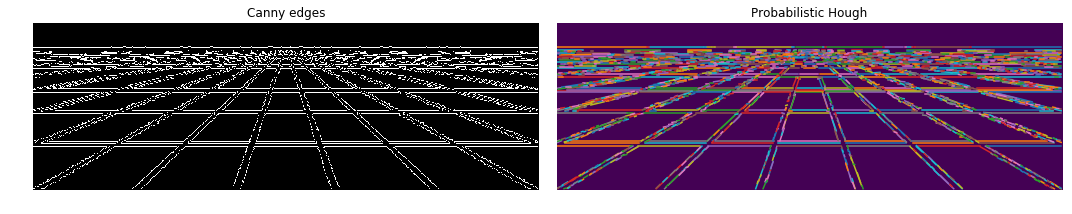

In [7]:
# Line finding using the Probabilistic Hough Transform
lines = probabilistic_hough_line(edges, threshold=10, line_length=3,
                                 line_gap=2)

# Generating figure 2
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(edges, cmap=cm.gray)
ax[0].set_title('Canny edges')

ax[1].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[1].set_xlim((0, image.shape[1]))
ax[1].set_ylim((image.shape[0], 0))
ax[1].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

In [8]:
def slope(x1, y1, x2, y2):
    if x2-x1 == 0:
        return 'undf'
    return (y2-y1)/(x2-x1)

## https://stackoverflow.com/questions/3252194/numpy-and-line-intersections

In [9]:
def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

In [10]:
pre_ransac = []
for ele in lines:
    pre_ransac.append(slope(ele[0][0], ele[0][1], ele[1][0], ele[1][1]))

## Remove horizontal lines from the probablistic hough transform results, this will lessen the number of intersections not leading to vanishing points for the ransac algorithm, however, we save the horizontal lines to use their y coordinates to find the horizon line

In [11]:
no_horizontal_lines = []
no_horizontal_slopes = []
horizontal_lines = []
for i in range(len(pre_ransac)):
    if str(pre_ransac[i]) == 'undf':
        continue
    elif abs(pre_ransac[i]) < 2: 
        horizontal_lines.append(lines[i])
        continue
    no_horizontal_lines.append(lines[i])
    no_horizontal_slopes.append(pre_ransac[i])


In [12]:
intersections = []
for i in tqdm(range(len(no_horizontal_lines) - 1)):
    for j in range(i+1, len(no_horizontal_lines)):
        cur_intersect = get_intersect(no_horizontal_lines[i][0], no_horizontal_lines[i][1], \
                                      no_horizontal_lines[j][0], no_horizontal_lines[j][1])
        # if points are parellel (inf, inf), do not include and go to next iteration
        if(str(cur_intersect[0]) == 'inf'):
            continue
        intersections.append(cur_intersect)

100%|██████████| 100/100 [00:00<00:00, 122.46it/s]


## The figure below shows all intersections of lines from the probablistic hough transform

100%|██████████| 4108/4108 [00:14<00:00, 218.16it/s]


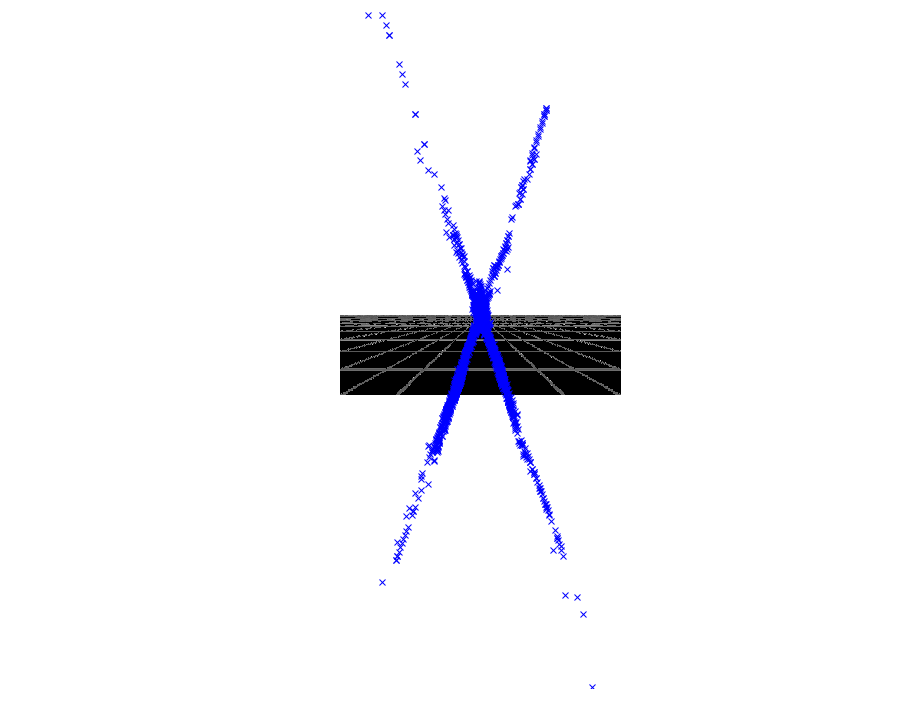

In [13]:
fig, axes = plt.subplots(figsize=(15,10))

axes.imshow(image, cmap=cm.gray)
for i in tqdm(range(len(intersections))):
    axes.plot(intersections[i][0],intersections[i][1], 'bx', label='point')
axes.set_xlim((-1000, image.shape[1]+1000))
axes.set_ylim((image.shape[0] + 1000, - 1000))
axes.set_axis_off()

plt.tight_layout()
plt.show()

## Take all of the horizontal lines we threw out and take their y coordinates, the minimum y value will be the horizon line

In [14]:
horizontal_y_coordinates = []
for ele in horizontal_lines:
    horizontal_y_coordinates.append(ele[1][1])

## Splitting the list of intersections into lists of x and y coordinates to use for ransac

In [15]:
intersections_x = list(zip(*intersections))[0]
intersections_y = list(zip(*intersections))[1]

## https://stackoverflow.com/questions/52280944/python-finding-multiple-linear-trend-lines-in-a-scatter-plot

## The figure below shows the lines found from the ransac algorithm

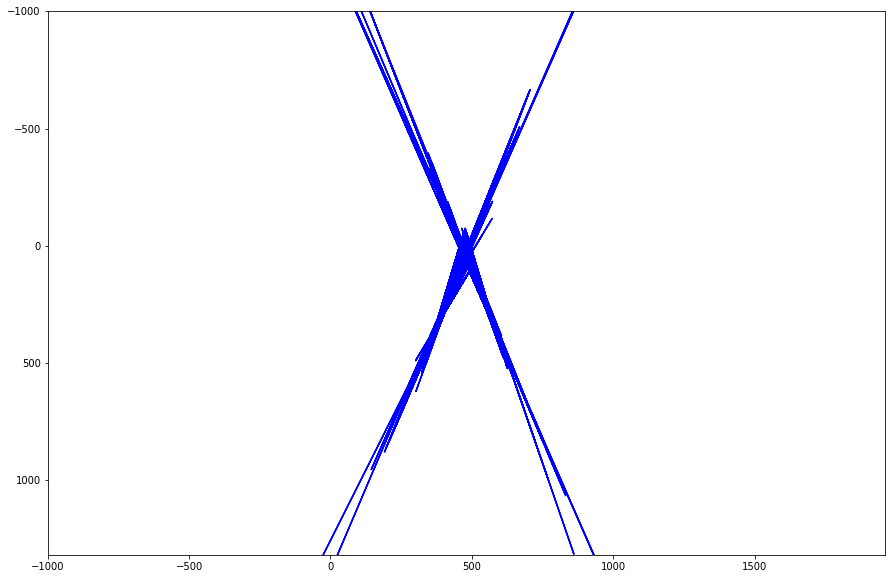

In [16]:
ransac_lines = []
idx = 0
fig, ax = plt.subplots(figsize=(15,10))

xs = np.array(intersections_x)
ys = np.array(intersections_y)

MIN_SAMPLES = 2

while len(xs) > MIN_SAMPLES:
    # build design matrix for linear regressor
    X = np.ones((len(xs), 2))
    X[:, 1] = xs

    ransac = linear_model.RANSACRegressor(
        residual_threshold=.3, min_samples=MIN_SAMPLES
    )

    res = ransac.fit(X, ys)

    # vector of boolean values, describes which points belong
    # to the fitted line:
    inlier_mask = ransac.inlier_mask_

    # plot point cloud:
    xinlier = xs[inlier_mask]
    yinlier = ys[inlier_mask]
    
    ransac_lines.append(list(zip(xinlier, yinlier)))

    ax.plot(xinlier, yinlier, "-b")

    # only keep the outliers:
    xs = xs[~inlier_mask]
    ys = ys[~inlier_mask]
        
ax.set_xlim((-1000, image.shape[1]+1000))
ax.set_ylim((image.shape[0] + 1000, - 1000))
plt.show()

## Taking ransac lines, computing the intersections of them

In [17]:
ransac_intersections = []
for i in tqdm(range(len(ransac_lines) - 1)):
    for j in range(i+1, len(ransac_lines)):
        cur_intersect = get_intersect(ransac_lines[i][0], ransac_lines[i][1], \
                                      ransac_lines[j][0], ransac_lines[j][1])
        # if points are parellel (inf, inf), do not include and go to next iteration
        if(str(cur_intersect[0]) == 'inf'):
            continue
        ransac_intersections.append(cur_intersect)

100%|██████████| 66/66 [00:00<00:00, 167.41it/s]


## This figure shows all of the intersections from the ransac lines

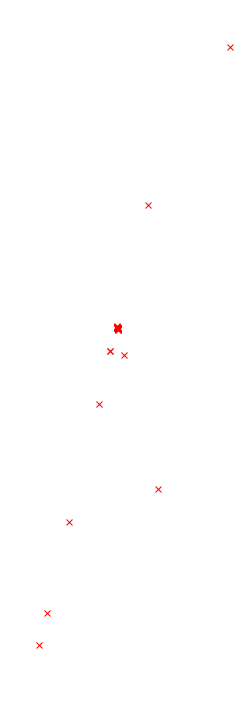

In [18]:
fig, axes = plt.subplots(figsize=(15,10))

axes.imshow(image, cmap=cm.gray)
for i in range(len(ransac_intersections)):
    axes.plot(ransac_intersections[i][0], ransac_intersections[i][1], 'bx', label='point', color='r')
axes.set_axis_off()

plt.tight_layout()
plt.show()

## Removing intersections not near the horizon line

In [19]:
ransac_thresholded_intersections = []
for element in ransac_intersections:
    if abs(element[1] - min(horizontal_y_coordinates)) > 10:
           continue
    ransac_thresholded_intersections.append(element)

## Plotting the ransac intersection points near the horizon line

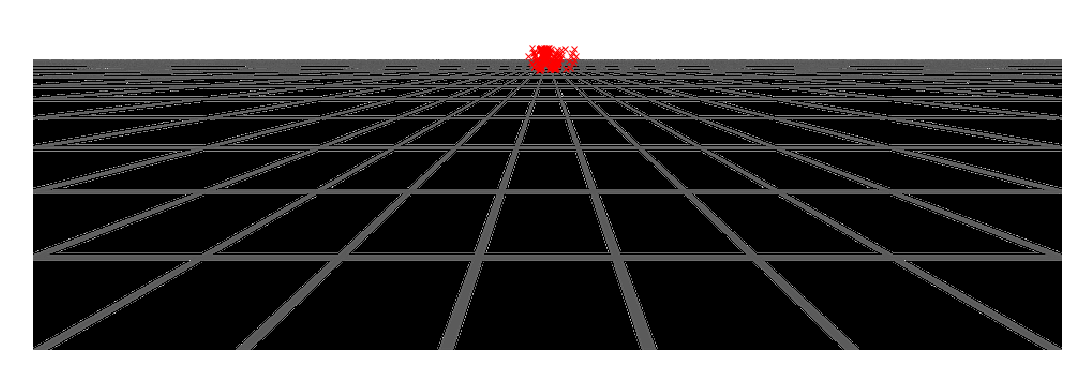

In [20]:
fig, axes = plt.subplots(figsize=(15,10))
axes.imshow(image, cmap=cm.gray)

for i in range(len(ransac_thresholded_intersections)):
        axes.plot(ransac_thresholded_intersections[i][0],ransac_thresholded_intersections[i][1], 'bx', label='point', color='r')

axes.set_axis_off()

plt.tight_layout()
plt.show()

## Clustering the ransac intersections so we can find the horizon line + vanishing points

In [21]:
# def point_distance(p1, p2):
#     return sqrt((p2[0] - p1[0])**2 + (p2[1]-p2[0])**2)

In [22]:
# for i in range(len(ransac_intersections)):
#     ransac_intersections[i] = list(ransac_intersections[i])

In [23]:
# intersection_neighbors = []
# for i in range(len(ransac_intersections) - 1):
#     count = 0
#     for j in range(len(ransac_intersections)):
#         if point_distance(ransac_intersections[i], ransac_intersections[j]) < 150:
#             count += 1
#     intersection_neighbors.append(count)

In [24]:
# fig, axes = plt.subplots(figsize=(15,10))
# axes.imshow(image, cmap=cm.gray)

# for i in range(len(intersection_neighbors)):
#     if intersection_neighbors[i] > 80:
#         axes.plot(ransac_intersections[i][0],ransac_intersections[i][1], 'bx', label='point', color='r')

# axes.set_axis_off()

# plt.tight_layout()
# plt.show()

## Challenges

The first challenge was limiting the runtime of finding the intersection of the lines produced by the hough transform.  The transform produced many extraneous vertical lines that only slowed down computation and we excluded those from our list of salient lines.  In addition we also increased the minimum length a line had to be again in hope of speeding up runtime.  The hough transform produced a copious amount of lines that froze our computers after about an hour of running.  

The second major challenge was clustering point into a single point. It 
was at this point that was decided to use a simpler image that had a clear vanishing point.  The result was a much simpler design than what we had, therefore reminant of our old code can be seen above in comment format.  However when we were using a more complex image we tried many techniques to cluster point to no avail such as k-means, manually clustering, and geometric algorithms.  None produced the desired output so we concluded with a simpler image.  The difference was immediate and beneficial.






An overarching third challenge was the use of hardcoded parameters for some functions.  Without the aid of machine learning in this instance we couldn't pinpoint proper thresholds.  With a properly trained network we believe it would be able to predict the values of these parameters for an image.  So for potential future work on this project would be to implement such a model that would assist our process of finding vanish points in an image.



## Evaluation

Our evaluation of our project was done qualitatively due to the nature of the project.